# View Available GPUs

In [7]:
!nvidia-smi

Fri Feb  5 17:43:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   36C    P0    53W / 300W |   3272MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   

# Create A Dask cluster

In [8]:
# dask-scheduler --port 9000 &

In [9]:
# dask-cuda-worker localhost:9000 &

In [10]:
# import dask
# from dask.distributed import Client

# client = Client('localhost:9000')
# client

In [12]:
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster(dashboard_address=':8003')
client = Client(cluster)
client

/conda/envs/rapids/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8003 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41161 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:46759 Dashboard: http://127.0.0.1:41161/status,Cluster Workers: 2 Cores: 2 Memory: 810.04 GB


# Generate a dataset and write it to disk

In [13]:
import cudf
import numpy as np

# Generate random data into cudf dataframe
def random_df(nrows):
    return cudf.DataFrame({
        'a': np.random.binomial(n=1, p=0.5, size=(nrows,)),
        'b': np.random.normal(size=(nrows,)),
        'c': np.random.normal(size=(nrows,)),
        'd': np.random.normal(size=(nrows,))
    })

random_df(100).head()

,a,b,c,d
0,1,-1.612976,0.463353,-0.493276
1,1,-0.853612,-0.939478,0.647514
2,1,0.388585,0.131806,-0.445440
3,1,-1.300765,1.229424,0.170058
4,1,0.511461,-1.832502,-0.618016


In [14]:
# Save dataframe into local for dask_cudf reading
random_df(20_000_000).to_csv('0.csv', index=False)
random_df(20_000_000).to_csv('1.csv', index=False)
random_df(20_000_000).to_csv('2.csv', index=False)
random_df(20_000_000).to_csv('3.csv', index=False)

# Read the dataset with dask_cudf

In [15]:
import dask_cudf
from dask.distributed import wait

# Read data using dask_cudf
df = dask_cudf.read_csv('*.csv', )
df.head()

,a,b,c,d
0,1,0.785553,-0.099518,-0.133224
1,0,0.767261,-0.127868,-0.098959
2,1,-0.025745,0.769099,0.355489
3,1,-0.729033,0.161392,-0.259226
4,1,-0.215830,1.354625,1.004491


In [17]:
df

,a,b,c,d
npartitions=12,,,,
,int64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


# Parse dataset filenames into a column using dask.delayed

In [18]:
from dask.delayed import delayed
from glob import glob

# Read data using dask+cudf and add filename into a column
@delayed
def load_df(fname):
    df = cudf.read_csv(fname)
    df['part'] = int(fname.split('.')[0])
    return df

# Convert cudf into dask_cudf
df = dask_cudf.from_delayed(
    [load_df(f) for f in glob('*.csv')]
)
df.head()

,a,b,c,d,part
0,1,0.785553,-0.099518,-0.133224,0
1,0,0.767261,-0.127868,-0.098959,0
2,1,-0.025745,0.769099,0.355489,0
3,1,-0.729033,0.161392,-0.259226,0
4,1,-0.215830,1.354625,1.004491,0


In [19]:
df

,a,b,c,d,part
npartitions=4,,,,,
,int64,float64,float64,float64,int64
,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


# Simple Computation using dask.dataframe

In [20]:
# Do a calcualtion in dask_cudf dataframe
df['saxpy'] = df.b * df.c + df.d
df.head()

,a,b,c,d,part,saxpy
0,1,0.785553,-0.099518,-0.133224,0,-0.211401
1,0,0.767261,-0.127868,-0.098959,0,-0.197067
2,1,-0.025745,0.769099,0.355489,0,0.335688
3,1,-0.729033,0.161392,-0.259226,0,-0.376887
4,1,-0.215830,1.354625,1.004491,0,0.712123


# Map a custom computation using dask.delayed

In [21]:
# Create a custom function and call it for each dask partition.
# The reasom for doing something like is to create partions of data,
# without data shuffling, and let cudf work on each partition of data
@delayed
def saxpy(df):
    df['saxpy_cust'] = df.b * df.c + df.d
    return df

df = dask_cudf.from_delayed(
    [saxpy(p) for p in df.to_delayed()]
)
df.head()

,a,b,c,d,part,saxpy,saxpy_cust
0,1,0.785553,-0.099518,-0.133224,0,-0.211401,-0.211401
1,0,0.767261,-0.127868,-0.098959,0,-0.197067,-0.197067
2,1,-0.025745,0.769099,0.355489,0,0.335688,0.335688
3,1,-0.729033,0.161392,-0.259226,0,-0.376887,-0.376887
4,1,-0.215830,1.354625,1.004491,0,0.712123,0.712123


# Map a CUDA UDF computation using dask.delayed

In [22]:
from numba import cuda

# Create an UDFs and call it for each dask partition.
@cuda.jit
def _saxpy(s, a, x, y):
    i = cuda.grid(1)
    if i < a.size:
        s[i] = a[i] * x[i] + y[i]

@delayed
def saxpy(df):
    df['saxpy_cuda'] = cuda.device_array(len(df))
    _saxpy.forall(len(df))(
        df['saxpy_cuda'], df['b'], df['c'], df['d']
    )
    return df

df = dask_cudf.from_delayed(
    [saxpy(p) for p in df.to_delayed()]
)
df.head()

,a,b,c,d,part,saxpy,saxpy_cust,saxpy_cuda
0,1,0.785553,-0.099518,-0.133224,0,-0.211401,-0.211401,-0.211401
1,0,0.767261,-0.127868,-0.098959,0,-0.197067,-0.197067,-0.197067
2,1,-0.025745,0.769099,0.355489,0,0.335688,0.335688,0.335688
3,1,-0.729033,0.161392,-0.259226,0,-0.376887,-0.376887,-0.376887
4,1,-0.215830,1.354625,1.004491,0,0.712123,0.712123,0.712123


In [23]:
# Show the delayed dataframe which not execuated yet.
df

,a,b,c,d,part,saxpy,saxpy_cust,saxpy_cuda
npartitions=4,,,,,,,,
,int64,float64,float64,float64,int64,float64,float64,float64
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


# dask.dataframe closely mimics Pandas API, but executes lazily and distributed

In [24]:
# Groupby the delayed df by 'part' column and calculate the sum of 'saxpy' column
result = df.groupby('part')['saxpy'].sum()
result

<dask_cudf.Series | 45 tasks | 1 npartitions>

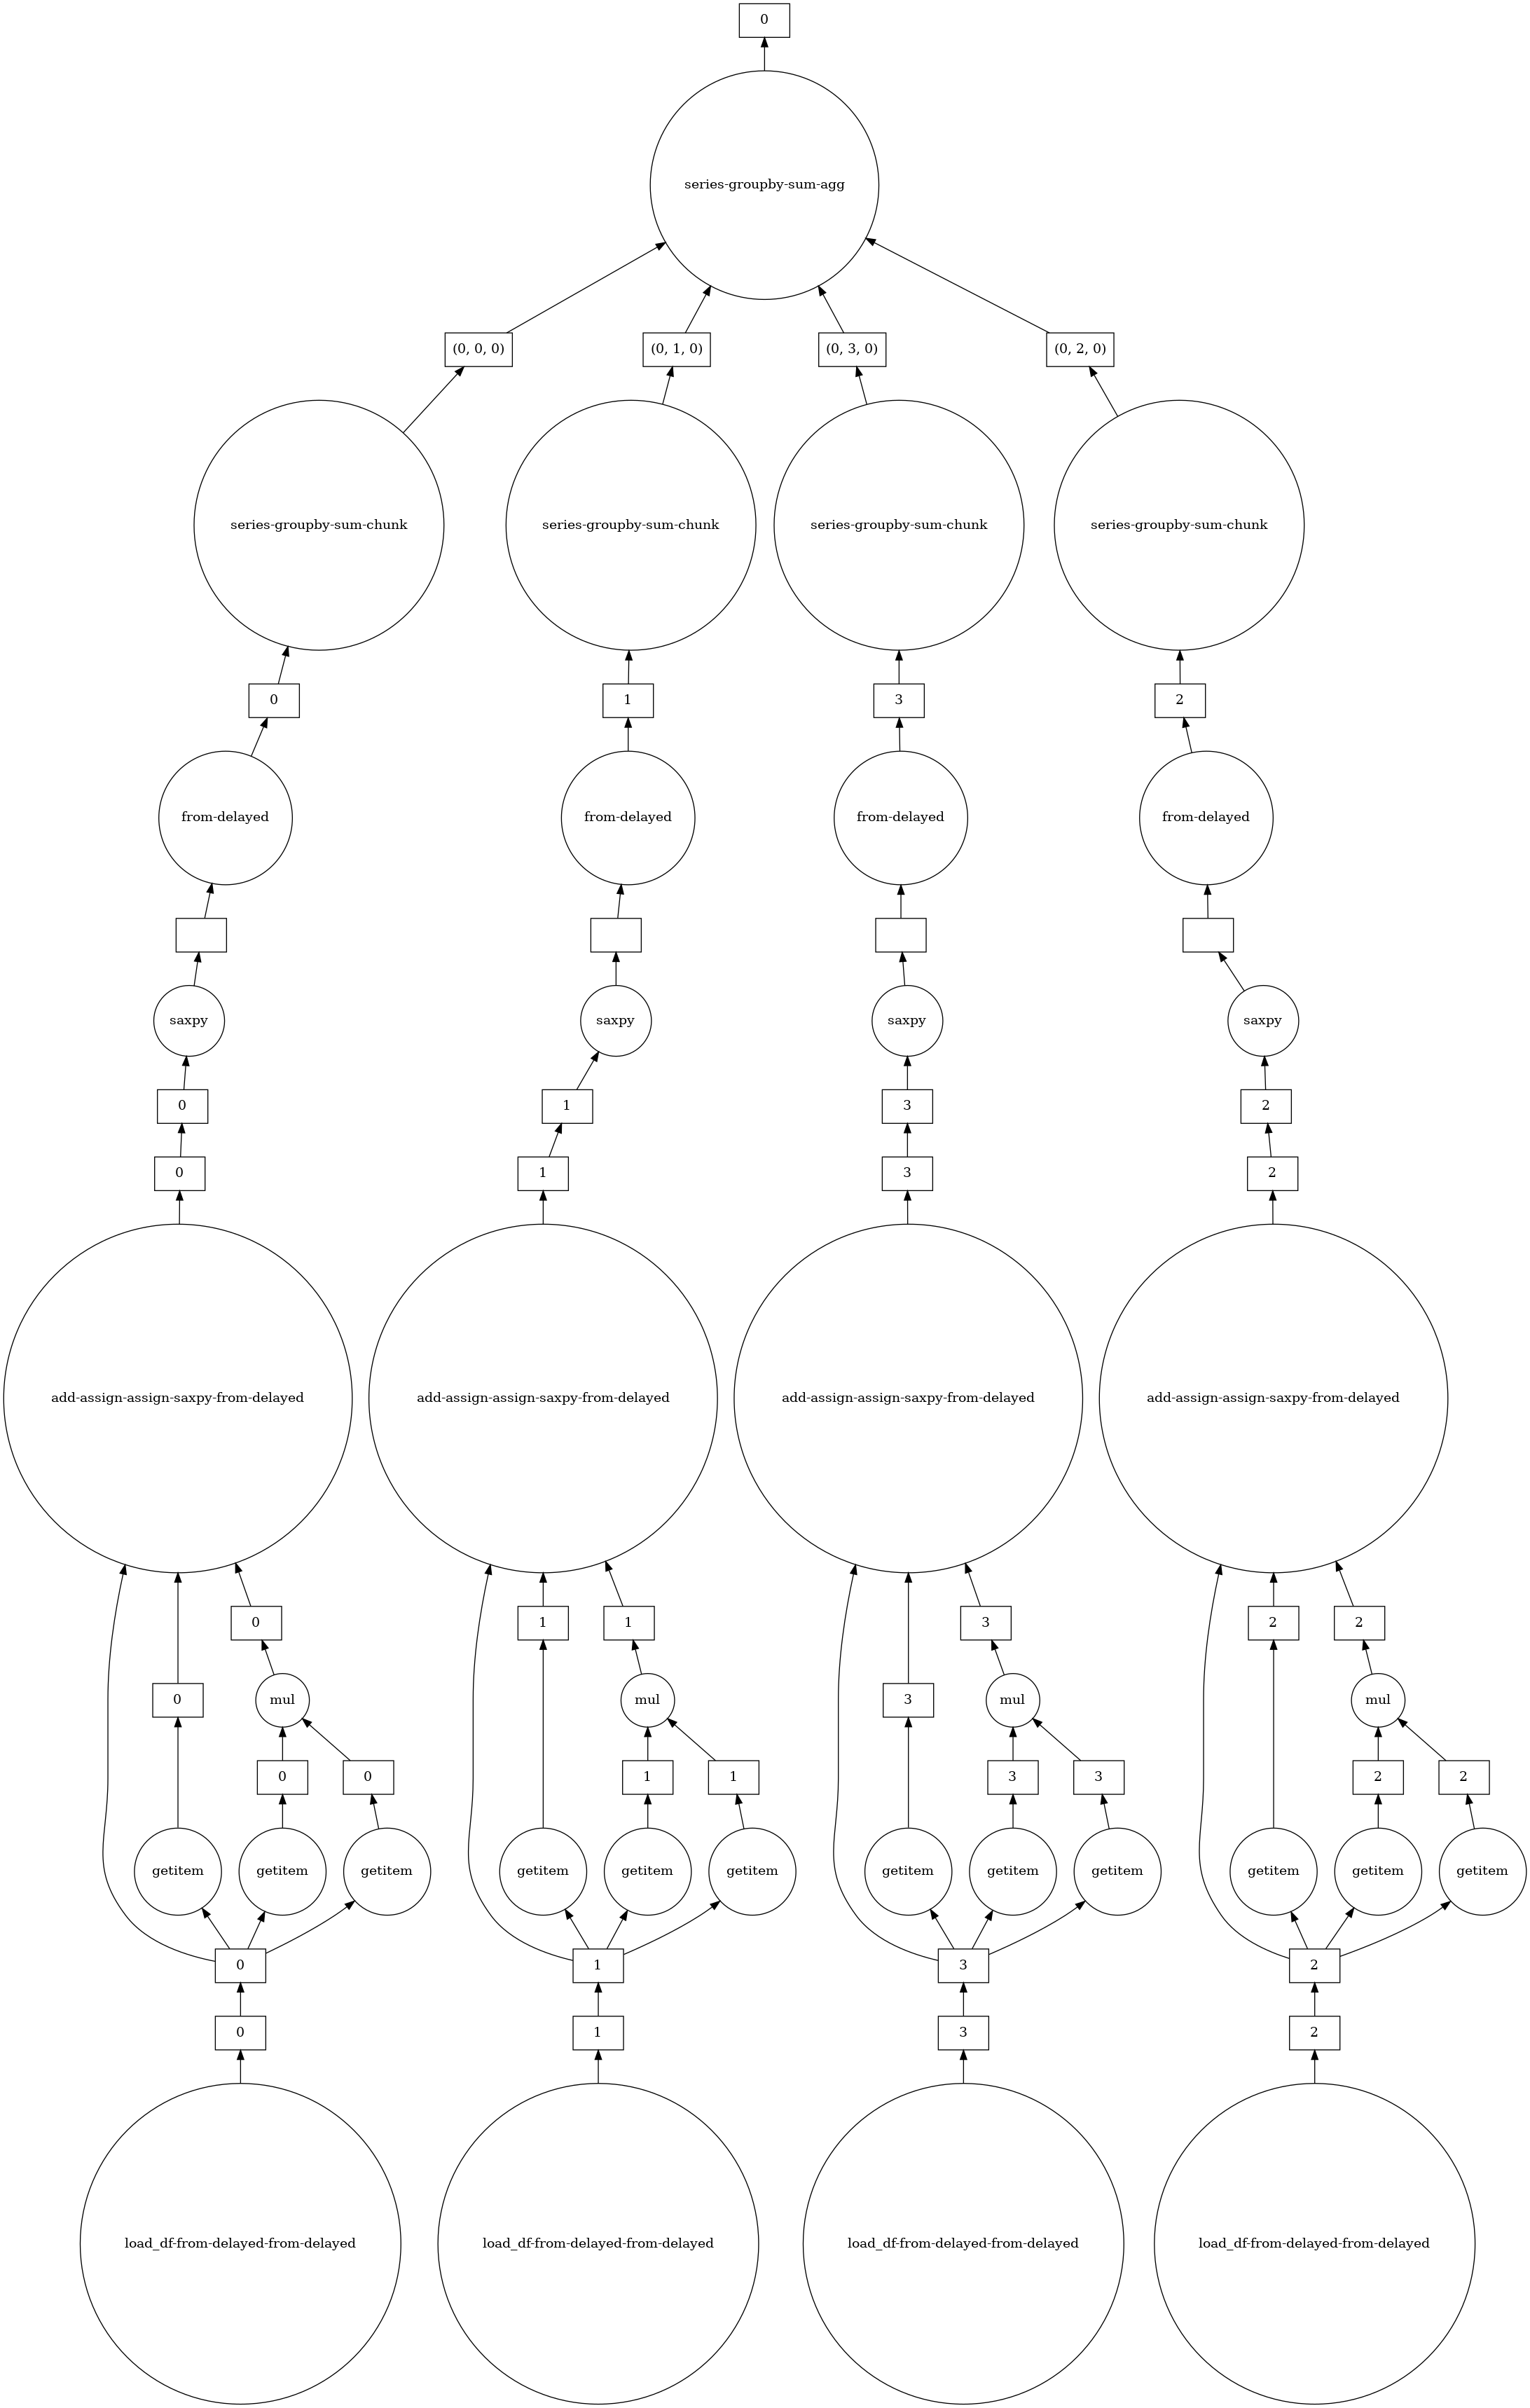

In [25]:
import os
try:
    import graphviz
except ModuleNotFoundError:
    os.system('apt update')
    os.system('apt install -y graphviz')
    os.system('conda install -c conda-forge graphviz -y')
    os.system('conda install -c conda-forge python-graphviz -y')

# Show the task graph
result.visualize()

In [26]:
%%time
# Compute the delayed dataframe and keep them in the GPU
result.persist() 

CPU times: user 47.4 ms, sys: 49.2 ms, total: 96.6 ms
Wall time: 61.7 ms


<dask_cudf.Series | 1 tasks | 1 npartitions>

# Clean up

In [ ]:
client.close()